# Custom RandomSearchCV Implementation
In this notebook, we will develop custom RandomizedSearchCV code and utilize the code to find the best hyperparameter for a k-NN classifier. Later we will visualize classification hyperplanes wit the optimal hyperparameters generated.

In [1]:
# Importing libraries 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from random import sample
import random
from functools import reduce
from sklearn.metrics import accuracy_score

In [2]:
#Generating the data
x, y = make_classification(n_samples = 100000, n_features = 2, n_informative=2,n_redundant=0)
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify = y, random_state = 651)

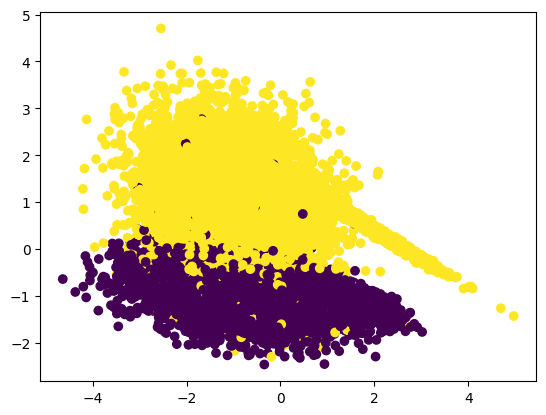

In [3]:
# Plotting the data
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(x_test[:,0], x_test[:,1],c=y_test)
plt.show()

In [4]:
# Defining the RandomSearchCV

def RandomSearchCV(x_train, y_train, classifier, param_range, folds): 
    '''
    Conducts Randomized Search on hyper parameters on parameters provided on data provided for a given classifier

    Args: 
    x_train: numpy array of shape, (n,d)
    y_train: numpy array of shape, (n,) or (n,1)
    classifier: its typically KNeighborsClassifier()
    param_range: its a tuple like (a,b) a < b
    folds: an integer, represents number of folds we need to devide the data and test our model

    Returns: 
    1. Train score: as the mean of training scores obtained by considering all but one fold as the test set. 
    This process is repeated for a given classifier using a random set of parameters introduced by the param_range function. 
    The number of folds determines how many times this process is repeated for cross-validation."

    2. Test score: as the mean of test scores obtained by sondering that one fold as the test set and treating other folds as train. 
    This process is repeated for a given classifier using a random set of parameters. The number of folds determins how many times 
    process is repeated. 

    3. Dictionary - {params: parameterlist}: Dictionary containing key 'params' and value as all the list of parameters considered
    by the function.  
    ''' 
    trainscores, testscores = [], []
    # Generating 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params"
    params = set(random.sample(range(param_range[0],param_range[1]), k = 10))
        
    # Dividing numbers ranging from  0 to len(X_train) into groups= folds
    totindexlist = list(range(len(x_train))) # Generating a list of numbers equal to length of train data
    indexsplitlist = [] # Defining an empty list into which split arrays will be inserted
    
    for f in range(0,len(x_train), int(len(x_train)/folds)): # Splitting the data into folds number of groups
        indexsplitlist.append(totindexlist[f:f+int(len(x_train)/folds)])
    
    if len(indexsplitlist[-1]) < len(indexsplitlist[-2]):
        indexsplitlist[-2] = (indexsplitlist[-2]+indexsplitlist[-1]) # Concatenating the tail list which has less than fold number of elements, with its previous
        del indexsplitlist[-1] # Deleting the tail list after concatenating it with the previous list
    
 
    for hyperparameter in list(params):
        trainscores_folds = []
        testscores_folds  = []

        # Creating empty list which will be populated
        train_indices = []
        intermitent_train_indices = []
        test_indices = []

        for x in reversed(range(len(indexsplitlist))):
            # Generating a copy of indexsplitlist everytime to ensure the modifications to newindexsplit doesn't permeate down the loop
            newindexsplitlist = indexsplitlist.copy()
            test_indices.append(newindexsplitlist.pop(x))# Appending the test indices generated
            intermitent_train_indices.append(newindexsplitlist) # Appending the rest of the list as train indices

        # Flattening the list of lists(of indices) for every element in intermitent_train_indices
        for y in intermitent_train_indices:
            train_indices.append(reduce(lambda p,q: p+q, y))

        for indexval in range(len(train_indices)):
            X_train = x_train[train_indices[indexval]]
            Y_train = y_train[train_indices[indexval]]
            X_test  = x_train[test_indices[indexval]]
            Y_test  = y_train[test_indices[indexval]]

            classifier.n_neighbors = hyperparameter
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))

        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
        parameterlist = list(params)
        parameterlist.sort()
        
    return trainscores, testscores, {'params': parameterlist}

In [5]:
# Calling the function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and storing the returned values into "train_score", and "cv_scores"
from sklearn.neighbors import KNeighborsClassifier
train_score, cv_scores, parameters = RandomSearchCV(x_train, y_train, KNeighborsClassifier(n_jobs = -1),(1,50),10)

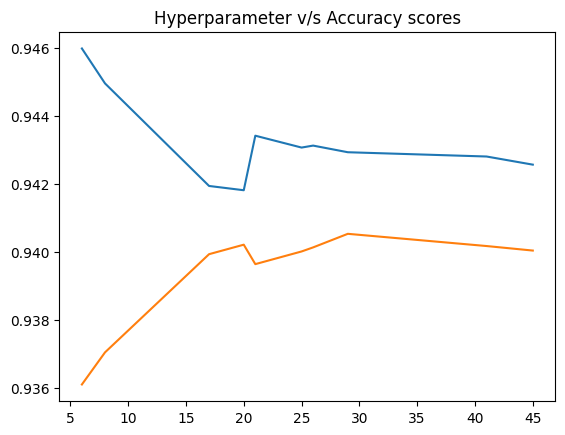


 [6, 8, 17, 20, 21, 25, 26, 29, 41, 45] 
 [1.8820888888888887, 1.8820059259259256, 1.881877037037037, 1.8820311111111112, 1.8830651851851852, 1.883088888888889, 1.8832666666666666, 1.883471111111111, 1.882985185185185, 1.882611851851852]
1.881877037037037


In [18]:
# Plotting hyper-parameter vs accuracy plot to choose the best hyperparameter
plt.plot(parameters['params'], train_score, label = 'Train')
plt.plot(parameters['params'], cv_scores, label = 'Cross Validation')
plt.title("Hyperparameter v/s Accuracy scores")
plt.show()

print("\n",parameters['params'], "\n", [train_score[y]+ cv_scores[y] for y in range(len(train_score))])
print(min([train_score[y]+ cv_scores[y] for y in range(len(train_score))]))

In [8]:
# Getting the best value of the hyperparameter 
trcvscore = [train_score[y]+ cv_scores[y] for y in range(len(train_score))]

best_hyperparameter = parameters['params'][trcvscore.index(min(trcvscore))]
print('Best Hyperparameter as determined by custom RandomizedSearchCV: {}'.format(best_hyperparameter))

Best Hyperparameter as determined by custom RandomizedSearchCV: 43


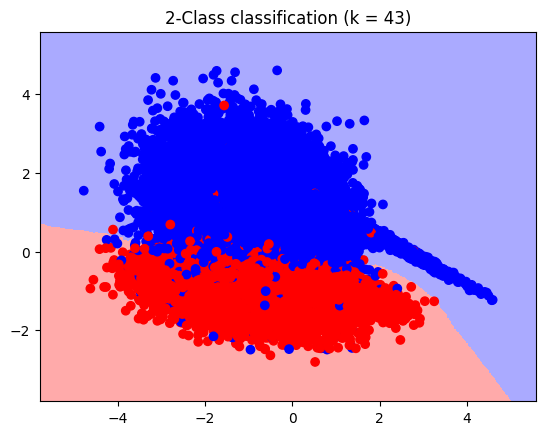

In [9]:
# Plotting the decision boundaries for the model initialized with the best hyperparameter, as shown in the previous cell of reference notebook

def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()
    
 
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = best_hyperparameter)
neigh.fit(x_train, y_train)
plot_decision_boundary(x_train[:, 0], x_train[:, 1], y_train, neigh)

The Randomized SerachCV colde has been successfully reproduced and implemented, and the best hyperparameter has been applied to the self-generated classification dataset. Additionally, the hyperplanes corresponding to the best hyperparameter have been visualized. 